In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms 
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch.nn.functional as F
import math
import time
from torch.optim import Adam
from skimage.metrics import structural_similarity as ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [43]:
# 將beta值域設定好後分割
def linear_scheduler(timesteps, start=0.0001, end=0.02):

    return torch.linspace(start, end, timesteps)

# 找到該time step下的beta值
def get_index_from_list(vals, t, x_shape):
    
    batch_size = t.shape[0]
    output = vals.gather(-1, t.cpu())
    return output.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# 按照time step將原圖加上不同程度高斯噪聲
def forward_diffusion_sample(x_0, t, device="cpu"):

    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

# Define beta schedule
T = 300
betas = linear_scheduler(timesteps=T)

# 預先計算好alpha和其連乘後的值以及其他公式中的必要值等等
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [44]:
IMG_SIZE = 64
BATCH_SIZE = 64
DIP_BATCH_SIZE = 1

# load dataset with transform
def load_transformed_dataset(image_dir):
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(), # Scales data into [0,1] 
        transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    ]
    data_transform = transforms.Compose(data_transforms)
    
    train = torchvision.datasets.ImageFolder(root=image_dir, transform=data_transform)

    return train

In [45]:
# 分別load dip和ddpm的dataset，並切割成長度1000
subset_indices = list(range(1000))
data_dip = load_transformed_dataset('./dip_dogs')
# data_dip = Subset(data_dip, subset_indices)
dataloader_dip = DataLoader(data_dip, batch_size=DIP_BATCH_SIZE, shuffle=True, drop_last=True)

data_ddpm = load_transformed_dataset('./ddpm_dogs')
data_ddpm = Subset(data_ddpm, subset_indices)
dataloader_ddpm = DataLoader(data_ddpm, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(len(data_dip))
print(len(data_ddpm))

1
1000


In [46]:

# 定義DIP模型
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [47]:
# 在DIP訓練過蟲中plot出輸入輸出的圖
def plot_dip_image(noisy, output, original):
    noisy = noisy.squeeze(0).cpu().detach().permute(1, 2, 0)
    output = output.squeeze(0).cpu().detach().permute(1, 2, 0)
    original = original.squeeze(0).cpu().detach().permute(1, 2, 0)
    noisy = (noisy + 1) / 2
    noisy = torch.clamp(noisy, 0, 1)
    output = (output + 1) / 2
    output = torch.clamp(output, 0, 1)
    original = (original + 1) / 2
    original = torch.clamp(original, 0, 1)
    plt.subplot(1, 3, 1)
    plt.imshow(noisy)
    plt.title('noisy_image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(output)
    plt.title('output_image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(original)
    plt.title('original_image')
    plt.axis('off')
    plt.show()


Epoch 0 | Loss: 0.23243126273155212


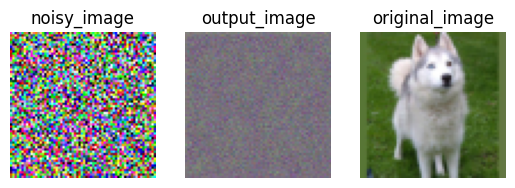

SSIM : -0.05413403767832034
----------------------------------------------
Epoch 100 | Loss: 0.18099312484264374


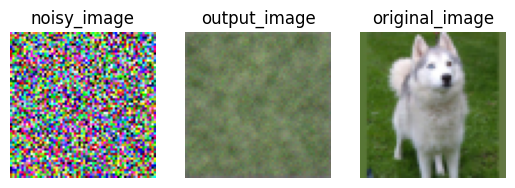

SSIM : 0.2717066378561926
----------------------------------------------
Epoch 200 | Loss: 0.11620493233203888


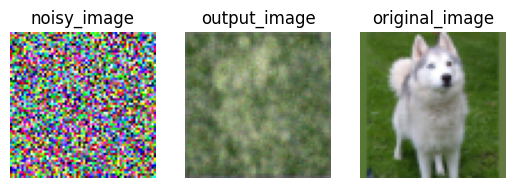

SSIM : 0.33439170355831827
----------------------------------------------
Epoch 300 | Loss: 0.04816719889640808


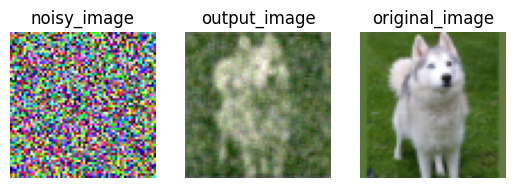

SSIM : 0.49410271242584836
----------------------------------------------


In [48]:

# 初始化DIP模型
model_dip = DIPModel().cuda()
criterion_dip = nn.MSELoss()
optimizer_dip = optim.Adam(model_dip.parameters(), lr=0.0001)

# 訓練DIP模型       

model_dip.to(device)
epochs = 301
loss_average = 0

img = torch.randn((1, 3, IMG_SIZE, IMG_SIZE), device=device)
img2 = img

for epoch in range(epochs):
    epoch_loss = []
    
    for step, batch in enumerate(dataloader_dip):
        optimizer_dip.zero_grad()
        output = model_dip(img)

        loss = criterion_dip(output.to(device), batch[0].to(device))
        
        epoch_loss.append(loss.item())
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_dip.parameters(), max_norm=1.0)
        optimizer_dip.step()

    if epoch % 100 == 0:
        loss_average = sum(epoch_loss) / len(epoch_loss)
        
        print(f"Epoch {epoch} | Loss: {loss_average}")
        plot_dip_image(img, output[0], batch[0][0])
        img_original = batch[0][0].detach().cpu().numpy().transpose(1, 2, 0)
        img_denoised = output[0].detach().cpu().numpy().transpose(1, 2, 0)
        ssim_value = ssim(img_original, img_denoised, win_size=3, multichannel=True, data_range=1.0)
        print(f"SSIM : {ssim_value}")
        print("----------------------------------------------")
                    

In [49]:
# DDPM Unet架構中的Conv結構
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        
        h = self.bn1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bn2(self.relu(self.conv2(h)))
        return self.transform(h)

In [50]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeds = math.log(10000) / (half_dim - 1)
        embeds = torch.exp(torch.arange(half_dim, device=device) * -embeds)
        embeds = time[:, None] * embeds[None, :]
        embeds = torch.cat((embeds.sin(), embeds.cos()), dim=-1)
        return embeds

In [51]:
# DDPM模型主要架構
class Unet(nn.Module):

    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                PositionalEncoding(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([ConvBlock(down_channels[i], down_channels[i+1], 
                                    time_emb_dim) for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([ConvBlock(up_channels[i], up_channels[i+1],
                                        time_emb_dim, up=True) for i in range(len(up_channels)-1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)
        
    def forward(self, x, timestep):
        
        # Embedd time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [52]:
# DDPM訓練過程中plot sample，按照plot step逐漸將純噪聲還原，並且每一步添加一些噪聲以保持隨機性
@torch.no_grad()
def sample_timestep(x, t):
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    noise = torch.randn_like(x)
    
    
    return model_mean, model_mean + torch.sqrt(posterior_variance_t) * noise

In [53]:
# 將tensor轉成圖片輸出
def show_tensor_image(image):
    
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    if len(image.shape) == 4:
        image = image[0, :, :, :]
        
    plt.imshow(reverse_transforms(image))
    plt.axis('off')


In [54]:
# 將sample timstep生成的圖分成十步放在subplot中
@torch.no_grad()
def sample_plot_image():
    img3 = model_dip(img2)
    plt.figure(figsize=(10,2))
    plt.axis('off')
    num_images = 10
    stepsize = max(1, int(T / num_images))  # 防止 stepsize 为 0
    #若是要有DIP輔助則下面一行為noisy_img = img3，若是不需要DIP輔助則為noisy_img = img2
    noisy_img = img3

    for i in range(T-1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img3, noisy_img = sample_timestep(noisy_img, t)
        if i % stepsize == 0:
            plt.subplot(1, int(num_images), int(i / stepsize + 1))
            show_tensor_image(img3.detach().cpu())
    plt.show()

    return img3

Epoch 0 | Loss: 1.0392907857894897 | training time: 0.03 sec


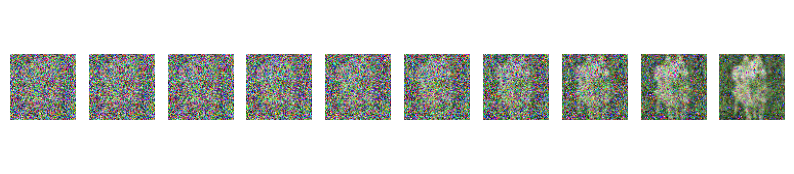

SSIM : 0.09517462915815746 | Generation Time : 1.45 sec
-----------------------------------------------------------
Epoch 100 | Loss: 0.11916676163673401 | training time: 5.07 sec


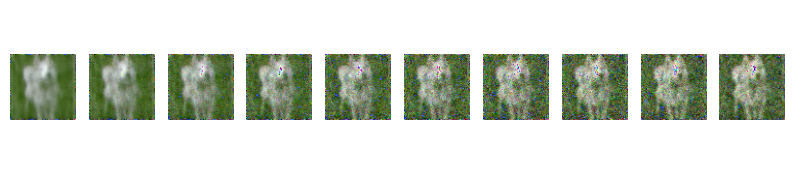

SSIM : 0.5674679367638401 | Generation Time : 1.47 sec
-----------------------------------------------------------
Epoch 200 | Loss: 0.06298115849494934 | training time: 4.99 sec


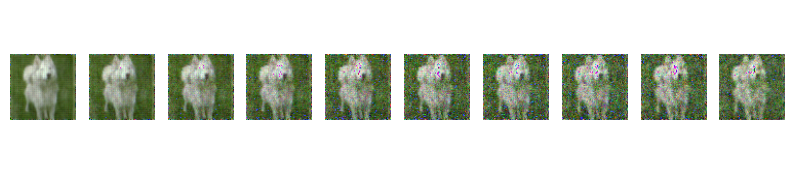

SSIM : 0.628270216580022 | Generation Time : 1.58 sec
-----------------------------------------------------------
Epoch 300 | Loss: 0.04529164358973503 | training time: 5.18 sec


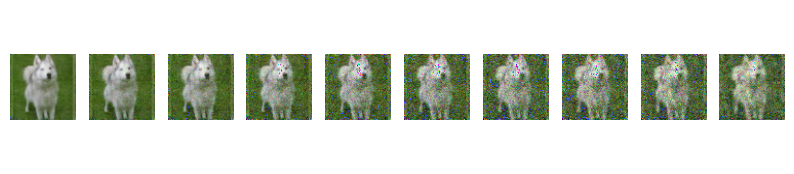

SSIM : 0.7558021001326614 | Generation Time : 1.55 sec
-----------------------------------------------------------
Epoch 400 | Loss: 0.06757836043834686 | training time: 5.44 sec


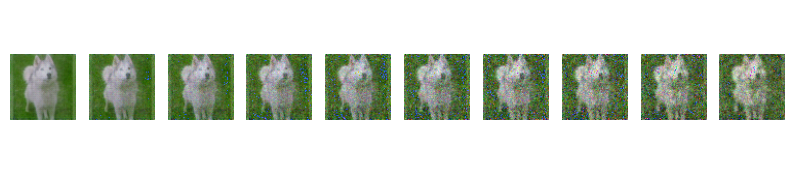

SSIM : 0.6984082146402488 | Generation Time : 1.80 sec
-----------------------------------------------------------
Epoch 500 | Loss: 0.02569407783448696 | training time: 5.34 sec


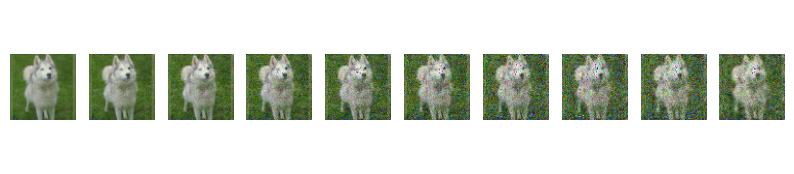

SSIM : 0.7433777822354176 | Generation Time : 1.59 sec
-----------------------------------------------------------
Epoch 600 | Loss: 0.02908777818083763 | training time: 4.96 sec


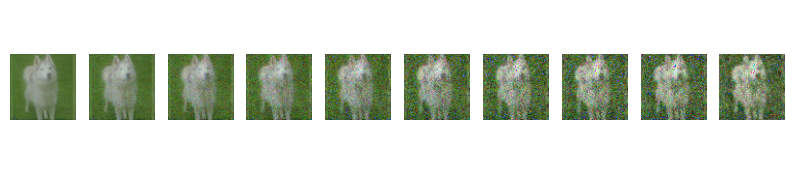

SSIM : 0.5913096008551229 | Generation Time : 1.55 sec
-----------------------------------------------------------
Epoch 700 | Loss: 0.029783954843878746 | training time: 4.99 sec


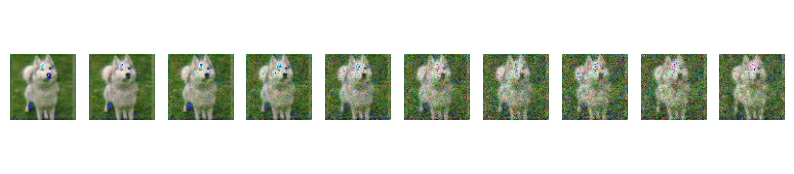

SSIM : 0.6851479620061347 | Generation Time : 1.41 sec
-----------------------------------------------------------
Epoch 800 | Loss: 0.014476921409368515 | training time: 4.97 sec


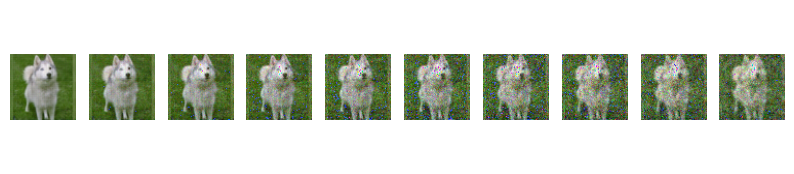

SSIM : 0.8238612916885102 | Generation Time : 1.45 sec
-----------------------------------------------------------
Epoch 900 | Loss: 0.02897552400827408 | training time: 5.02 sec


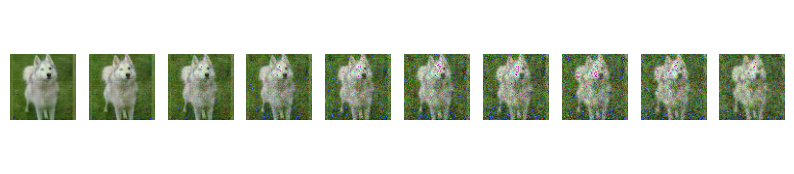

SSIM : 0.7215583639570603 | Generation Time : 1.64 sec
-----------------------------------------------------------
Epoch 1000 | Loss: 0.012924390845000744 | training time: 5.00 sec


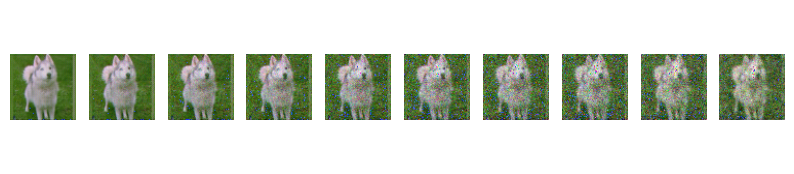

SSIM : 0.8239337319280937 | Generation Time : 1.46 sec
-----------------------------------------------------------


In [55]:
# 初始化DDPM
model = Unet()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.0003)
epochs = 1001

batch_losses = []
batch_ssim = []
start_time = time.time()

# 訓練DDPM

for epoch in range(epochs):
    epoch_ssim = []
    epoch_loss = []
    
    # 若要有DIP輔助要把下面一行training dataloader改為dataloader_dip否則為dataloader_ddpm
    for step, batch in enumerate(dataloader_dip):
        optimizer.zero_grad()
        
        # 若要更改training time step改下面一行T = 300...
        T = 300
        # 若要有DIP輔助要把下面一行batch size改為DIP_BATCH_SIZE否則為BATCH_SIZE
        t = torch.randint(3, T, (DIP_BATCH_SIZE,), device=device).long()
              
        x_0 = batch[0].to(device)
        
        x_noisy, noise = forward_diffusion_sample(x_0, t, device)

        noise_pred = model(x_noisy, t)
        
        loss = F.mse_loss(noise.to(device), noise_pred)
        
        batch_losses.append(loss.item())
        epoch_loss.append(loss.item())
                
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % 100 == 0:
            end_time = time.time()
            duration = end_time - start_time
            avr_loss = sum(epoch_loss) / len(epoch_loss)
            print(f"Epoch {epoch} | Loss: {avr_loss} | training time: {duration:02.2f} sec")
            # 若要更改sample plot step在下面改T = 100...
            T = 100
            start_time = time.time()
            test = sample_plot_image()
            end_time = time.time()
            img_original = x_0[0].detach().cpu().numpy().transpose(1, 2, 0)
            img_denoised = test[0].detach().cpu().numpy().transpose(1, 2, 0)
            ssim_value = ssim(img_original, img_denoised, win_size=3, multichannel=True, data_range=1.0)
            epoch_ssim.append(ssim_value)
            print(f"SSIM : {ssim_value} | Generation Time : {(end_time - start_time):02.2f} sec")
            print("-----------------------------------------------------------")
            start_time = time.time()
            
        

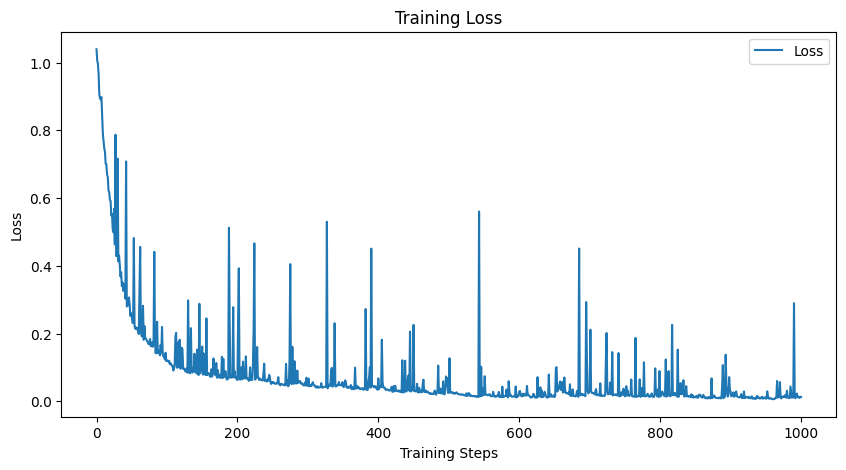

In [56]:
# plot出loss值收斂情況
plt.figure(figsize=(10,5))
plt.plot(batch_losses, label='Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()